# Demo: OpenMX and DeePMD-kit

DeePMD-kit is a software to implement Deep Potential. Here, I will try to demonstrate Interface from OpenMX to DeePMD-kit.

Regardless of which DFT calculation software is used, the information shown below must be transmitted to the DeePMD-kit side.

<div style="text-align: center;">【Available properties are (nframe: number of frames in the system, natoms: total number of atoms in the system)】</div>

| key          | type        | dimension            | are labels | description                           |
|--------------|-------------|----------------------|------------|---------------------------------------|
| 'atom_names' | list of str | ntypes               | False      | The name of each atom type            |
| 'atom_numbs' | list of int | ntypes               | False      | The number of atoms of each atom type |
| 'atom_types' | np.ndarray  | natoms               | False      | Array assigning type to each atom     |
| 'cells'      | np.ndarray  | nframes x 3 x 3      | False      | The cell tensor of each frame         |
| 'coords'     | np.ndarray  | nframes x natoms x 3 | False      | The atom coordinates                  |
| 'energies'   | np.ndarray  | nframes              | True       | The frame energies                    |
| 'forces'     | np.ndarray  | nframes x natoms x 3 | True       | The atom forces                       |
| 'virials'    | np.ndarray  | nframes x 3 x 3      | True       | The virial tensor of each frame       |

For more details, please check [dpdata repository](https://github.com/deepmodeling/dpdata/tree/master).

Assuming that "tensorflow" and "deepmd-kit" is pre-installed. 

In [ ]:
# pip install tensorflow
# pip install deepmd-kit

## How to apply for OpenMX format

To prepare minimum required, place the original `dpdata` on current directory, and make a file `openmx.py` and a folder named `openmx` in the appropriate location.

In [25]:
! tree dpdata/openmx

dpdata/openmx
├── __init__.py
├── __pycache__
│   ├── __init__.cpython-311.pyc
│   └── omx.cpython-311.pyc
└── omx.py

2 directories, 4 files


```
openmx
├── __init__.py
├── __pycache__
│   ├── __init__.cpython-311.pyc
│   └── omx.cpython-311.pyc
└── omx.py

2 directories, 4 files

```
is correct.

In [24]:
! tree dpdata/plugins

dpdata/plugins
├── 3dmol.py
├── __init__.py
├── __pycache__
│   ├── 3dmol.cpython-311.pyc
│   ├── __init__.cpython-311.pyc
│   ├── abacus.cpython-311.pyc
│   ├── amber.cpython-311.pyc
│   ├── ase.cpython-311.pyc
│   ├── cp2k.cpython-311.pyc
│   ├── deepmd.cpython-311.pyc
│   ├── dftbplus.cpython-311.pyc
│   ├── fhi_aims.cpython-311.pyc
│   ├── gaussian.cpython-311.pyc
│   ├── gromacs.cpython-311.pyc
│   ├── lammps.cpython-311.pyc
│   ├── list.cpython-311.pyc
│   ├── openmx.cpython-311.pyc
│   ├── psi4.cpython-311.pyc
│   ├── pwmat.cpython-311.pyc
│   ├── pymatgen.cpython-311.pyc
│   ├── qe.cpython-311.pyc
│   ├── rdkit.cpython-311.pyc
│   ├── siesta.cpython-311.pyc
│   ├── vasp.cpython-311.pyc
│   └── xyz.cpython-311.pyc
├── abacus.py
├── amber.py
├── ase.py
├── cp2k.py
├── deepmd.py
├── dftbplus.py
├── fhi_aims.py
├── gaussian.py
├── gromacs.py
├── lammps.py
├── list.py
├── openmx.py
├── psi4.py
├── pwmat.py
├── pymatgen.py
├── qe.py
├── rdkit.py
├── siesta.py
├── vasp.py
└── xyz.py



```
plugins
├── 3dmol.py
├── __init__.py
├── __pycache__
│   ├── 3dmol.cpython-311.pyc
│   ├── __init__.cpython-311.pyc
│   ├── abacus.cpython-311.pyc
│   ├── amber.cpython-311.pyc
│   ├── ase.cpython-311.pyc
│   ├── cp2k.cpython-311.pyc
│   ├── deepmd.cpython-311.pyc
│   ├── dftbplus.cpython-311.pyc
│   ├── fhi_aims.cpython-311.pyc
│   ├── gaussian.cpython-311.pyc
│   ├── gromacs.cpython-311.pyc
│   ├── lammps.cpython-311.pyc
│   ├── list.cpython-311.pyc
│   ├── openmx.cpython-311.pyc
│   ├── psi4.cpython-311.pyc
│   ├── pwmat.cpython-311.pyc
│   ├── pymatgen.cpython-311.pyc
│   ├── qe.cpython-311.pyc
│   ├── rdkit.cpython-311.pyc
│   ├── siesta.cpython-311.pyc
│   ├── vasp.cpython-311.pyc
│   └── xyz.cpython-311.pyc
├── abacus.py
├── amber.py
├── ase.py
├── cp2k.py
├── deepmd.py
├── dftbplus.py
├── fhi_aims.py
├── gaussian.py
├── gromacs.py
├── lammps.py
├── list.py
├── openmx.py
├── psi4.py
├── pwmat.py
├── pymatgen.py
├── qe.py
├── rdkit.py
├── siesta.py
├── vasp.py
└── xyz.py

2 directories, 44 files
```
is correct.

## How to prepare from command line

Please download sample files.

In [1]:
# ! git clone https://github.com/shigeandtomo/Demo work

Cloning into 'Demo'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 571 (delta 5), reused 13 (delta 3), pack-reused 556
Receiving objects: 100% (571/571), 549.46 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (353/353), done.


In [26]:
! ls

00.data         CH4_MD.py       Opt.txt         file.sh         train.sh
01.train        Cdia            README.md       geometry        traj
10.data         Cdia_MD.py      __pycache__     geometry.py     tree.std
11.train        H2O             abacus.png      gif             tree1.std
20.data         H2O+0.txt       abacus.txt      img             tree2.std
21.train        H2O.txt         constant_opt.py log
30.data         H2O_MD.py       demo.ipynb      omx2qe.py
31.train        Methane.txt     demo_copy.ipynb omxfile.sh
40.data         Opt.png         dpdata          todo.txt


### sample files description

1. `00.data` CH4 with ABACUS (, CP2K, or VASP)
1. `10.data` CH4 with OpenMX
1. `20.data` H2O with OpenMX

Each folder named `train` contains `input.json`, deepmd-kit input script.

In [3]:
# import os
# os.chdir("work")

In [3]:
# ! git clone https://github.com/deepmodeling/dpdata tmp

In [ ]:
# ! cp -r tmp/dpdata .

In [2]:
! cp -r openmx dpdata/
! cp openmx.py dpdata/plugins/

cp: openmx: No such file or directory
cp: openmx.py: No such file or directory


## Import libraries

Now, we can use deepmd with OpenMX. Then, import following libraries.

In [2]:
import os
import dpdata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ang2bohr = 1.88972612463
bohr2ang = 0.529177210903

#### Note: Even if "dpdata" has already been installed, the package named "dpdata" in the current directory is imported first.

## Table of contents

The demonstration with ABACUS from [DeePMD-kit Quick Start Tutorial](https://docs.deepmodeling.com/projects/deepmd/en/master/getting-started/quick_start.html)

The demonstration with OpenMX
1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
2. [Data preparation](#scrollTo=G-laa4YqQRji)
3. [Prepare input script](#scrollTo=G-laa4YqQRji)
4. [Train a model](#scrollTo=G-laa4YqQRji)
5. [Test a model](#scrollTo=G-laa4YqQRji)
6. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Example1】H2O

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
1. [Data preparation](#scrollTo=G-laa4YqQRji)
1. [Prepare input script](#scrollTo=G-laa4YqQRji)
1. [Train a model](#scrollTo=G-laa4YqQRji)
1. [Test a model](#scrollTo=G-laa4YqQRji)
1. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Example2】Cdia

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
1. [Data preparation](#scrollTo=G-laa4YqQRji)
1. [Prepare input script](#scrollTo=G-laa4YqQRji)
1. [Train a model](#scrollTo=G-laa4YqQRji)
1. [Test a model](#scrollTo=G-laa4YqQRji)
1. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Known problems】

【Linkage to tools】

【Reference】

## The demonstration with ABACUS from [DeePMD-kit Quick Start Tutorial](https://docs.deepmodeling.com/projects/deepmd/en/master/getting-started/quick_start.html)

### First, plot bond length and angles in the data from ABACUS.

length mean value = 1.10, angle mean value = 109.79


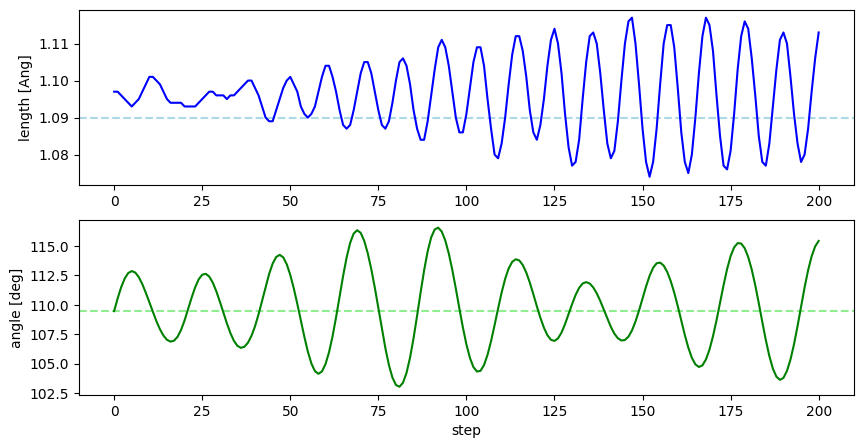

In [ ]:
### ABACUS data plot ###
data=np.genfromtxt("abacus.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(1000,2000)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(1000,2000)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,4].mean():3.2f}")
# plt.savefig("abacus.png")
plt.show()

In [ ]:
# load data of abacus/md format
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")
print("# the data contains %d frames" % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201, size=40, replace=False)

# other indexes are training_data
index_training = list(set(range(201)) - set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data"
data_training.to_deepmd_npy("00.data/abacus_md/training_data")

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy("00.data/abacus_md/validation_data")

print("# the training data contains %d frames" % len(data_training))
print("# the validation data contains %d frames" % len(data_validation))

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


In [ ]:
! dp neighbor-stat -s 00.data/abacus_md -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.045921
DEEPMD INFO    max_nbor_size: [4 1]


In [ ]:
! bash train.sh

first index = 0
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

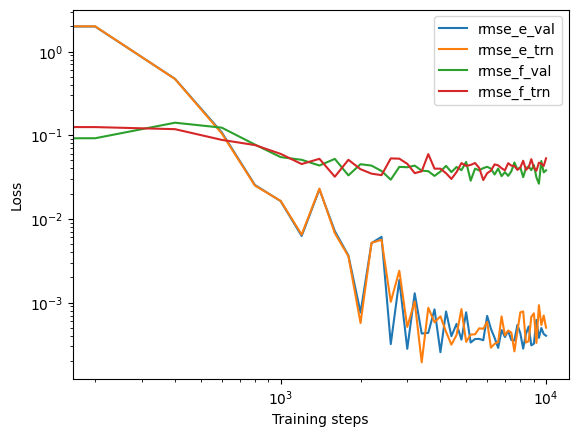

In [ ]:
with open("01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label=legend)
#     plt.plot(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [3]:
training_systems = dpdata.LabeledSystem(f"00.data/abacus_md/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"01.train/graph.pb")

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-26 13:58:24.654565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


As shown later, ABACUS data contains "virials", but OpenMX doesn't.

In [4]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 161
Atom Numbers       : 5
Including Virials  : Yes
Element List       :
-------------------
H  C
4  1

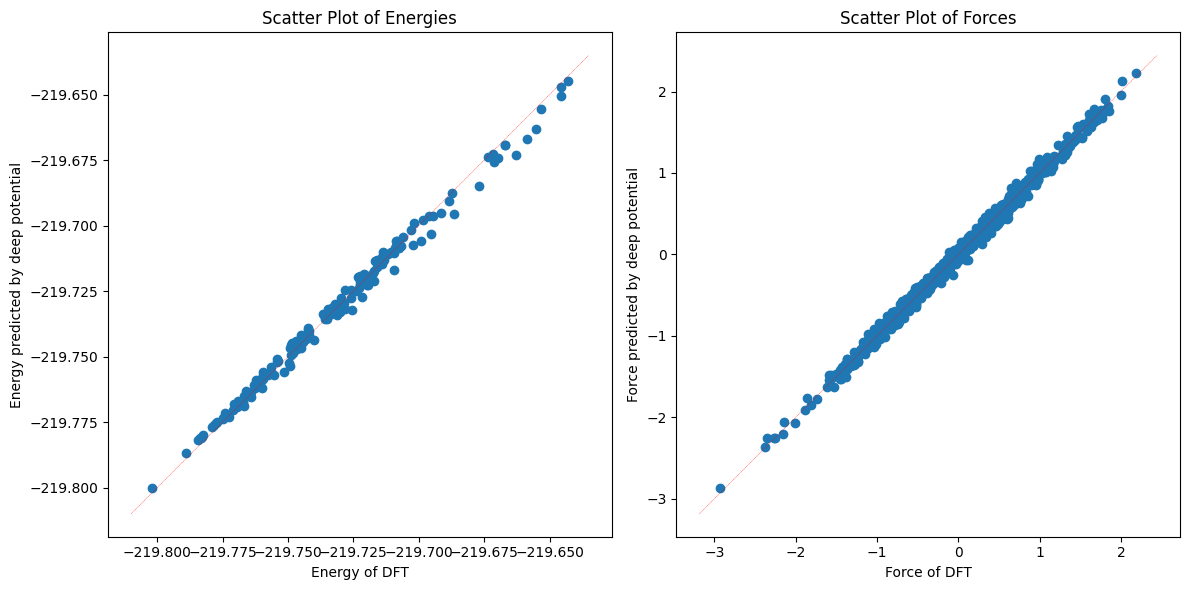

In [11]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


In [35]:
! python3 CH4_MD.py > abacus_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-26 16:41:36.142402: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [36]:
filename="abacus_nn"

df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-43.9312,-43.9597,0.0284,220.1
1,0.01,-43.9085,-43.9464,0.0379,293.3
2,0.02,-43.9082,-43.9325,0.0242,187.5
3,0.03,-43.9220,-43.9481,0.0260,201.3
4,0.04,-43.9065,-43.9322,0.0258,199.4
...,...,...,...,...,...
76,0.76,-43.9142,-43.9551,0.0409,316.3
77,0.77,-43.9154,-43.9554,0.0401,309.9
78,0.78,-43.9109,-43.9495,0.0386,298.8
79,0.79,-43.9167,-43.9545,0.0378,292.3


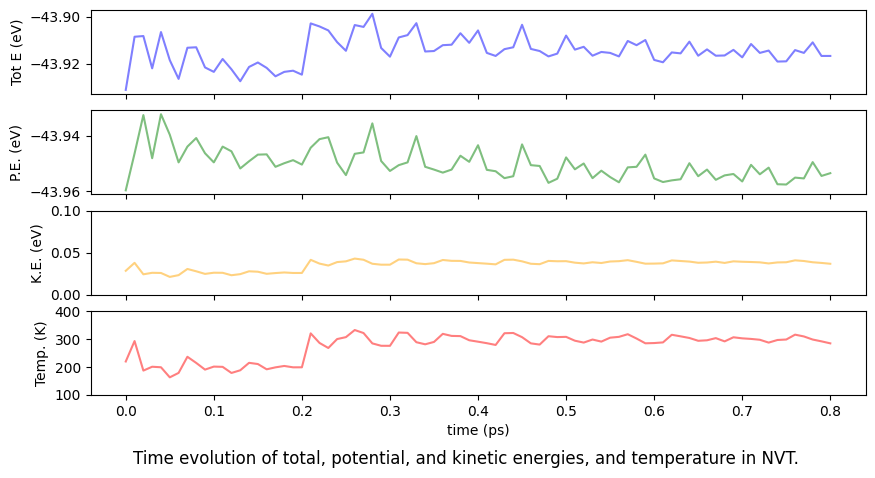

In [37]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.07


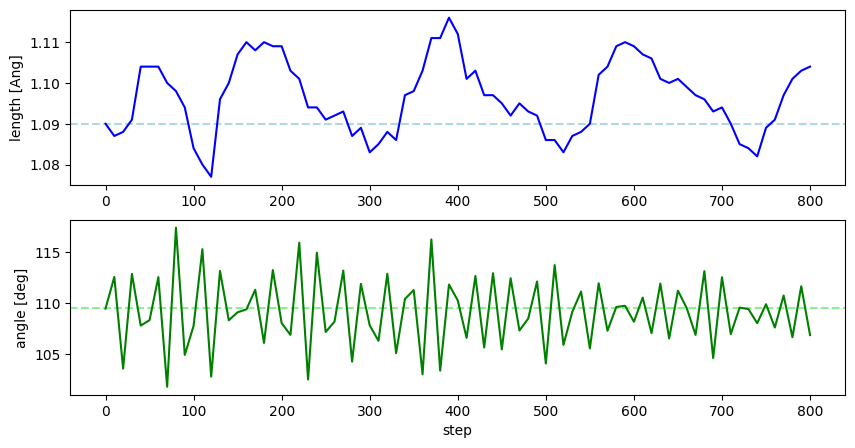

In [39]:
data=np.genfromtxt("abacus_nn.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,5], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,5].mean():3.2f}")
# plt.savefig("geometry/abacus_nn.png")
plt.show()

## The demonstration with OpenMX
Compare learning results from ABCUS and OpenMX to verify that the DeePMD-kit is functioning properly. (not contain "virials")

### 1.Get DFT data
Place the results of calculations by OpenMX in the directory named `00.data`.

Input file “CH4.dat ”:
```

#
# MD or Geometry Optimization
#

MD.Type                  NVT_NH        # Nomd|Opt|NVE|NVT_VS|NVT_NH
MD.maxIter                  200        # default=1
MD.TimeStep                 1.0        # default=0.5 (fs)
NH.Mass.HeatBath           30.0        # default = 20.0

<MD.TempControl
  2
  1    300.0
  100  300.0
MD.TempControl>
```

length mean value = 1.10, angle mean value = 109.43


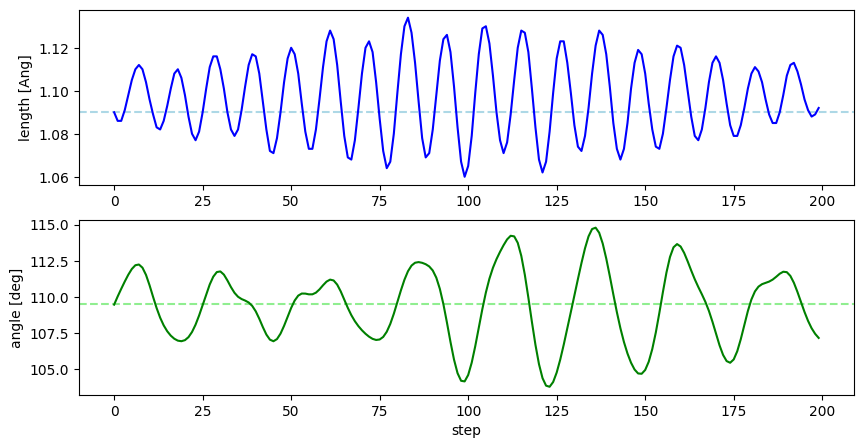

In [43]:
### OpenMX data plot ###
data=np.genfromtxt("openmx.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,5], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,5].mean():3.2f}")
# plt.savefig("geometry/openmx.png")
plt.show()

### 2.Data preparation

The variable named label is the number which identifies data directories.

In [14]:
label=1

In [14]:
data = dpdata.LabeledSystem(f'{label}0.data/Methane', fmt = 'openmx')
print('# the data contains %d frames' % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     

# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')      

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')

print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation))

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [127]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

In [128]:
training_systems # not include virials

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

### 3.Prepare input script

Input file “input.json ”:
```
"model": {
        "type_map":	["H", "C"],
        "descriptor" :{
            "type":		"se_e2_a",
            "sel":		"auto",
            "rcut_smth":	0.50,
            "rcut":		6.00,
            "neuron":		[25, 50, 100],
            "resnet_dt":	false,
            "axis_neuron":	16,
            "seed":		1,
            "_comment":		" that's all"
        },
        "fitting_net" : {
            "neuron":		[240, 240, 240],
            "resnet_dt":	true,
            "seed":		1,
            "_comment":		" that's all"
        },
```

### 4.Train a model
After the training script is prepared, we can start the training with DeePMD-kit by simply running

In [26]:
! dp neighbor-stat -s 10.data -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.029958484357501
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.029958
DEEPMD INFO    max_nbor_size: [4 1]


In [27]:
### Execute the deepmd-kit commands in sequence.　###
! bash train.sh

first index = 1
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.029958484357501
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd.

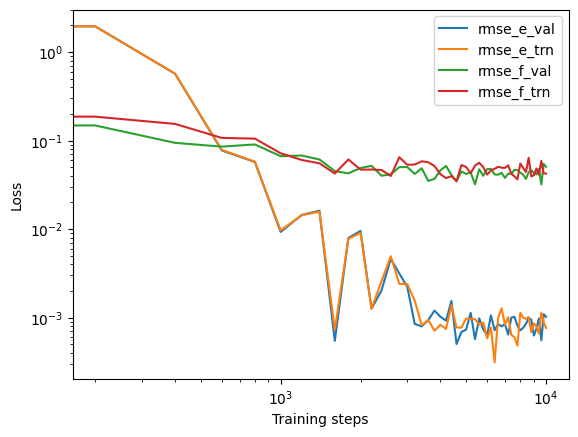

In [28]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model
The terminal should display the following

```
DEEPMD INFO    # ---------------output of dp test--------------- 
DEEPMD INFO    # testing system : ../00.data/validation_data
DEEPMD INFO    # number of test data : 40 
DEEPMD INFO    Energy MAE         : 6.695204e-02 eV
DEEPMD INFO    Energy RMSE        : 8.683650e-02 eV
DEEPMD INFO    Energy MAE/Natoms  : 3.719558e-03 eV
DEEPMD INFO    Energy RMSE/Natoms : 4.824250e-03 eV
DEEPMD INFO    Force  MAE         : 2.773996e-01 eV/A
DEEPMD INFO    Force  RMSE        : 3.574003e-01 eV/A
DEEPMD INFO    Virial MAE         : 3.173318e+00 eV
DEEPMD INFO    Virial RMSE        : 6.770684e+00 eV
DEEPMD INFO    Virial MAE/Natoms  : 1.762954e-01 eV
DEEPMD INFO    Virial RMSE/Natoms : 3.761491e-01 eV
DEEPMD INFO    # ----------------------------------------------- 
```

In [15]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

In [31]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

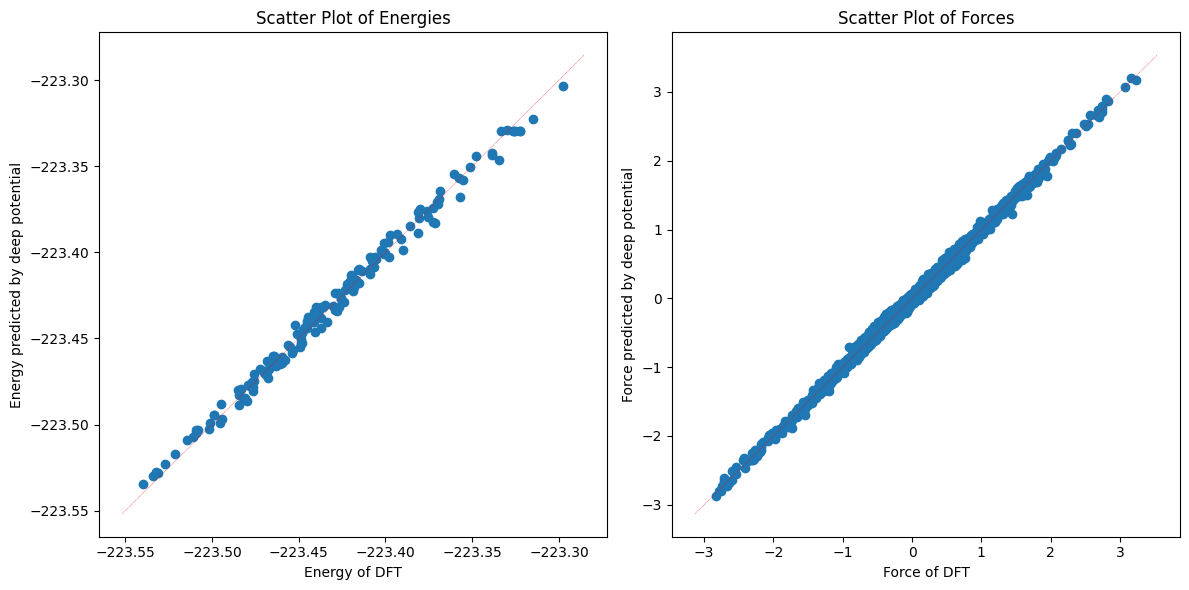

In [16]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [45]:
filename="openmx_nn"

In [47]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 CH4_MD.py > openmx_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-26 16:46:57.024457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [48]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-44.6938,-44.7098,0.0160,123.5
1,0.01,-44.6571,-44.6930,0.0358,277.1
2,0.02,-44.6663,-44.6830,0.0167,129.0
3,0.03,-44.6813,-44.7029,0.0216,167.0
4,0.04,-44.6769,-44.7068,0.0299,231.2
...,...,...,...,...,...
76,0.76,-44.6644,-44.7043,0.0399,308.6
77,0.77,-44.6659,-44.7039,0.0380,294.2
78,0.78,-44.6682,-44.7062,0.0379,293.3
79,0.79,-44.6688,-44.7081,0.0393,303.8


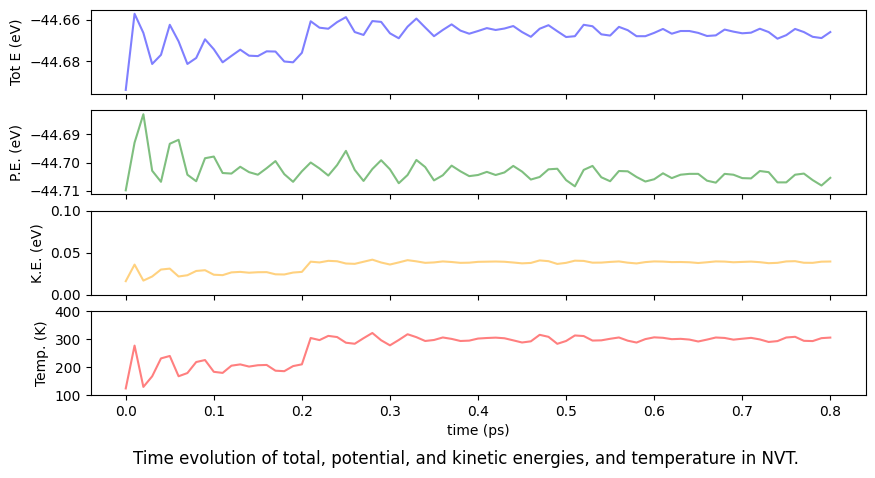

In [49]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.65


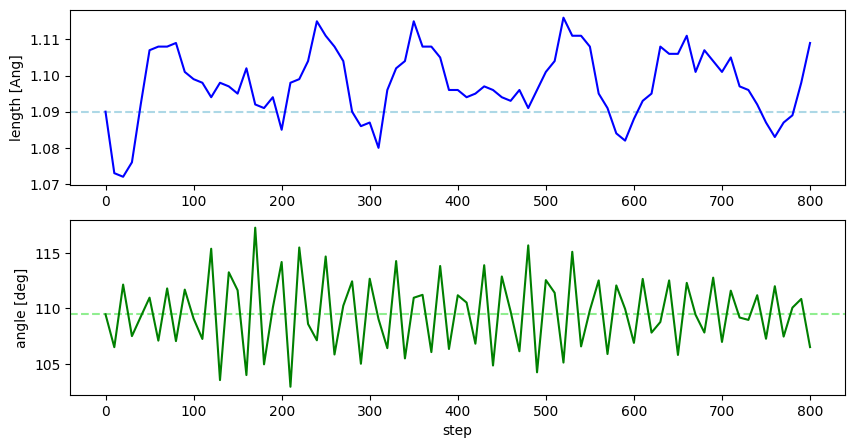

In [50]:
data=np.genfromtxt(f"{filename}.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,4].mean():3.2f}")
# plt.savefig(f"{filename}.png")
plt.show()

## 【Example1】H2O
There is no comparison with ABACUS.

### 1.Get DFT data

The table shows bond length and angles mean value during MD.
|                  | reference | calculation | Error(%) |
|------------------|-----------|-------------|----------|
| bond length (Å)  | 0.9584    | 0.970       |    1.21  |
| bond angle (deg) | 104.45    | 103.62      |   0.62231|

length mean value = 0.97, angle mean value = 103.80


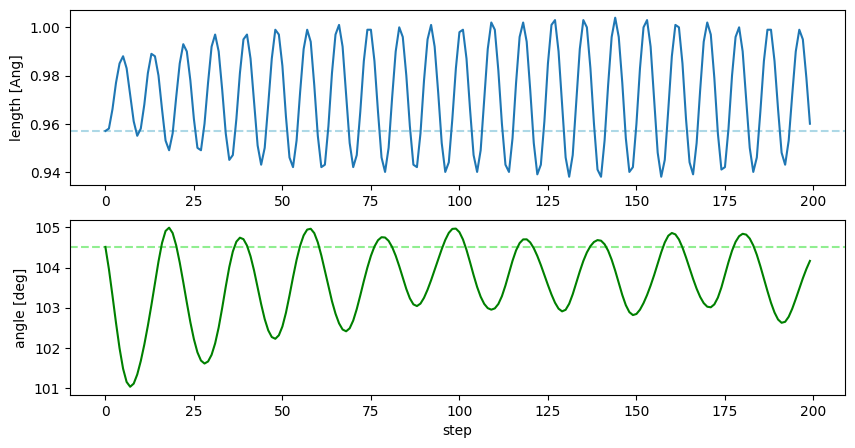

In [53]:
data=np.genfromtxt(f"H2O.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"graphic/{filename}.png")
print(f"length mean value = {data[100:,1].mean():1.2f}, angle mean value = {data[100:,3].mean():3.2f}")
plt.show()

### 2.Data preparation

In [17]:
label=2

In [149]:
data = dpdata.LabeledSystem(f'{label}0.data/H2O', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [187]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 3
Including Virials  : No
Element List       :
-------------------
O  H
1  2

### 3.Prepare input script

In [188]:
# ! dp neighbor-stat -s 20.data -r 6.0 -t O H
! bash train.sh

first index = 2
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9258628711099713
DEEPMD INFO    training data with max nbor size: [1 2]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

### 4.Train a model

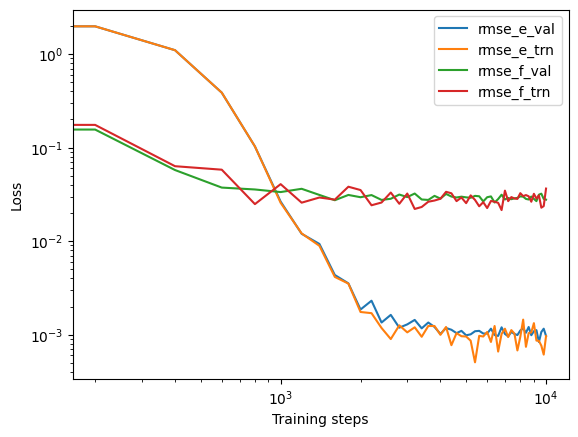

In [189]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

In [18]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

In [236]:
training_systems["energies"]

array([-475.56659457, -475.5573427 , -475.52033522, -475.50863432,
       -475.53448514, -475.53992742, -475.51053912, -475.53502937,
       -475.56278498, -475.54536969, -475.51570928, -475.51462083,
       -475.5434649 , -475.51897465, -475.54509758, -475.53911107,
       -475.52659384, -475.55271677, -475.55951961, -475.53040343,
       -475.55162831, -475.553261  , -475.52142367, -475.53040343,
       -475.55162831, -475.55434945, -475.53856685, -475.54210433,
       -475.55707059, -475.55571002, -475.54292067, -475.54292067,
       -475.5573427 , -475.55489368, -475.54482547, -475.54972352,
       -475.55543791, -475.5475466 , -475.55026774, -475.56060807,
       -475.55843116, -475.55353311, -475.55598213, -475.55870327,
       -475.55897539, -475.55298888, -475.5475466 , -475.55271677,
       -475.55979173, -475.55353311, -475.55679848, -475.56060807,
       -475.54890717, -475.56060807, -475.55571002, -475.55217254,
       -475.55815904, -475.56224075, -475.55571002, -475.54999

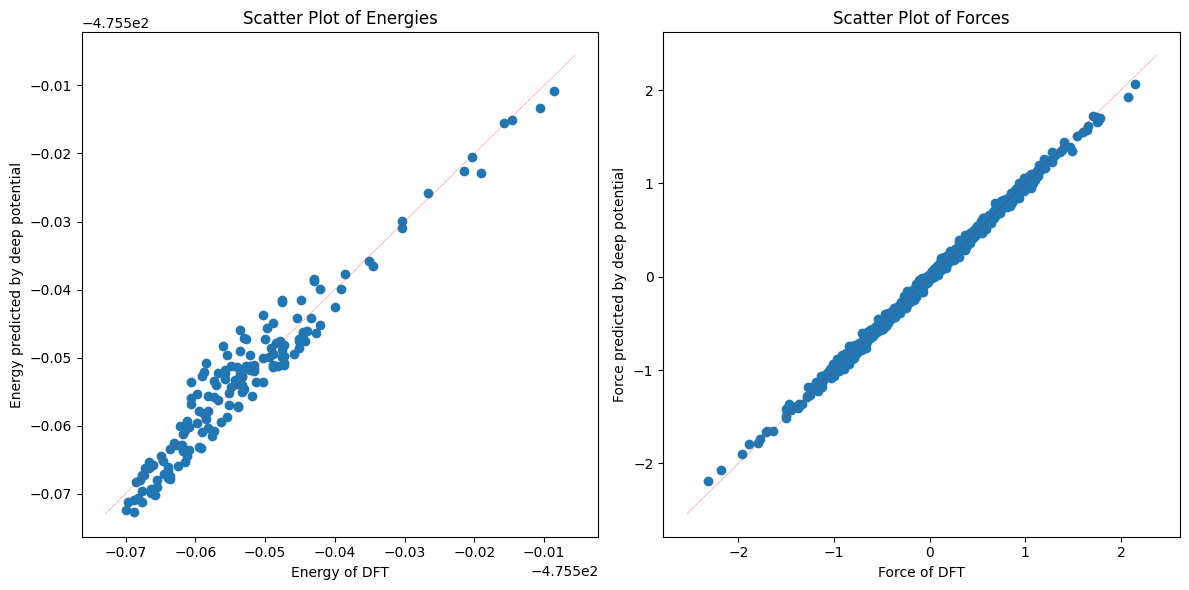

In [19]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [192]:
filename="H2O_nn"

In [193]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 H2O_MD.py > H2O_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-25 18:48:30.003567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [194]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-158.5001,-158.5218,0.0217,168.2
1,0.01,-158.4714,-158.5152,0.0437,338.3
2,0.02,-158.4674,-158.5060,0.0385,297.9
3,0.03,-158.4769,-158.5105,0.0337,260.6
4,0.04,-158.4792,-158.5131,0.0339,262.0
...,...,...,...,...,...
76,0.76,-158.4846,-158.5235,0.0389,300.8
77,0.77,-158.4832,-158.5227,0.0395,305.9
78,0.78,-158.4820,-158.5216,0.0397,307.1
79,0.79,-158.4843,-158.5230,0.0387,299.1


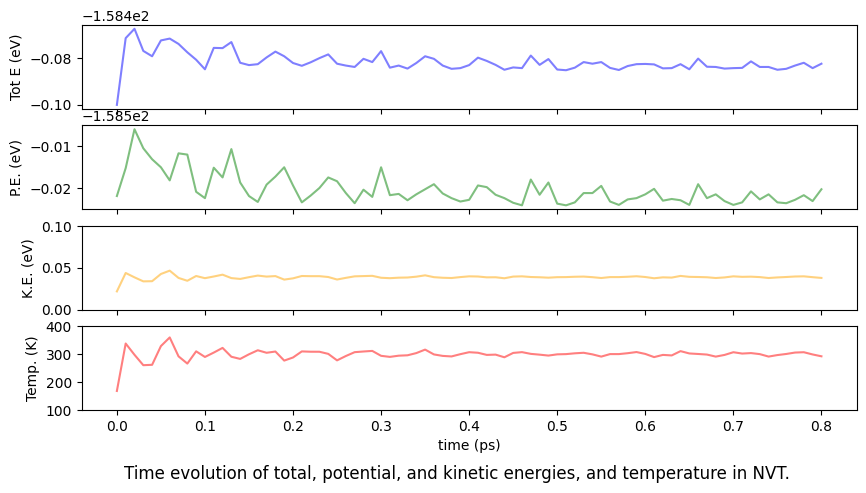

In [195]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

### 7.Bond length and bond angle

|                  | reference | OpenMX calculation | DeePMD calculation |
|------------------|-----------|-------------|----------|
| bond length (Å)  | 0.9584    | 0.970       |    0.97  |
| bond angle (deg) | 104.45    | 103.62      |   103.69|

length mean value = 0.97, angle mean value = 103.69


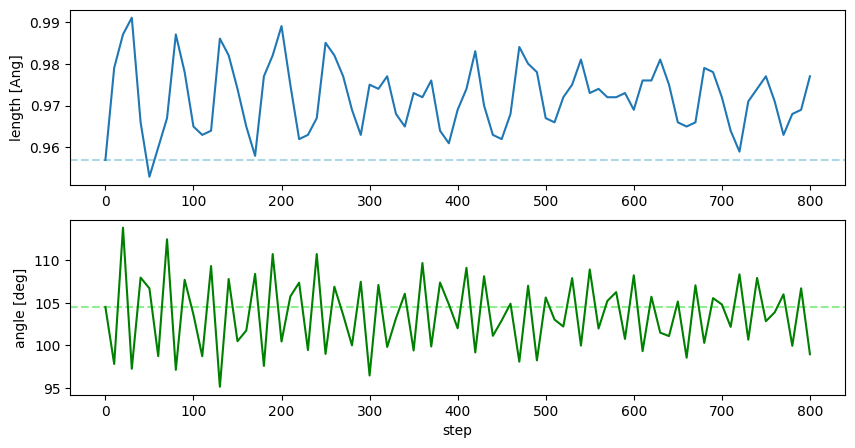

In [54]:
data=np.genfromtxt(f"H2O_nn.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"graphic/{filename}.png")
print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,3].mean():3.2f}")
plt.show()

## 【Known problems】

### AssertionError

```
<Atoms.UnitVectors
     -3.5600000     0.0000000     3.5600000
      0.0000000     3.5600000     3.5600000
     -3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
has no problem, but
```
<Atoms.UnitVectors
     3.5600000     0.0000000     3.5600000
     0.0000000     3.5600000     3.5600000
     3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
makes a bug.

```
  File "/Users/syanase/share/idea2/dpdata/system.py", line 672, in rot_frame_lower_triangular
    assert np.linalg.det(rot) == 1
           ^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
```

## 【Linkage to tools】

1. [OpenMX](https://www.openmx-square.org/)
1. [DeePMD-kit](https://github.com/deepmodeling/deepmd-kit)
1. [ASE](https://wiki.fysik.dtu.dk/ase/)

## 【Reference】
1. [MATLANTIS Atomistic Simulation Tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/index.html)